## 기본 설정

필수 모듈을 불러오고 그래프 출력 관련 기본 설정을 정한다.

In [1]:
# 파이썬 ≥3.5
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 0. 데이터 가져오기

#### 0.1 데이터 다운로드

* 온라인 상에 저장된 압축파일을 가져오기
* 압축파일을 풀어 csv 파일로 저장

In [7]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "notebooks/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [8]:
fetch_housing_data()

#### 0.2 데이터 구조 훑어보기

* csv 파일을 판다스 데이터프레임으로 불러오기

In [9]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [10]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


* 데이터셋 기본 정보 확인하기

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 범주형 데이터 탐색

In [12]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* 수치형 데이터 탐색

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* 수치형 데이터 특성별 히스토그램

그림 저장: attribute_histogram_plots


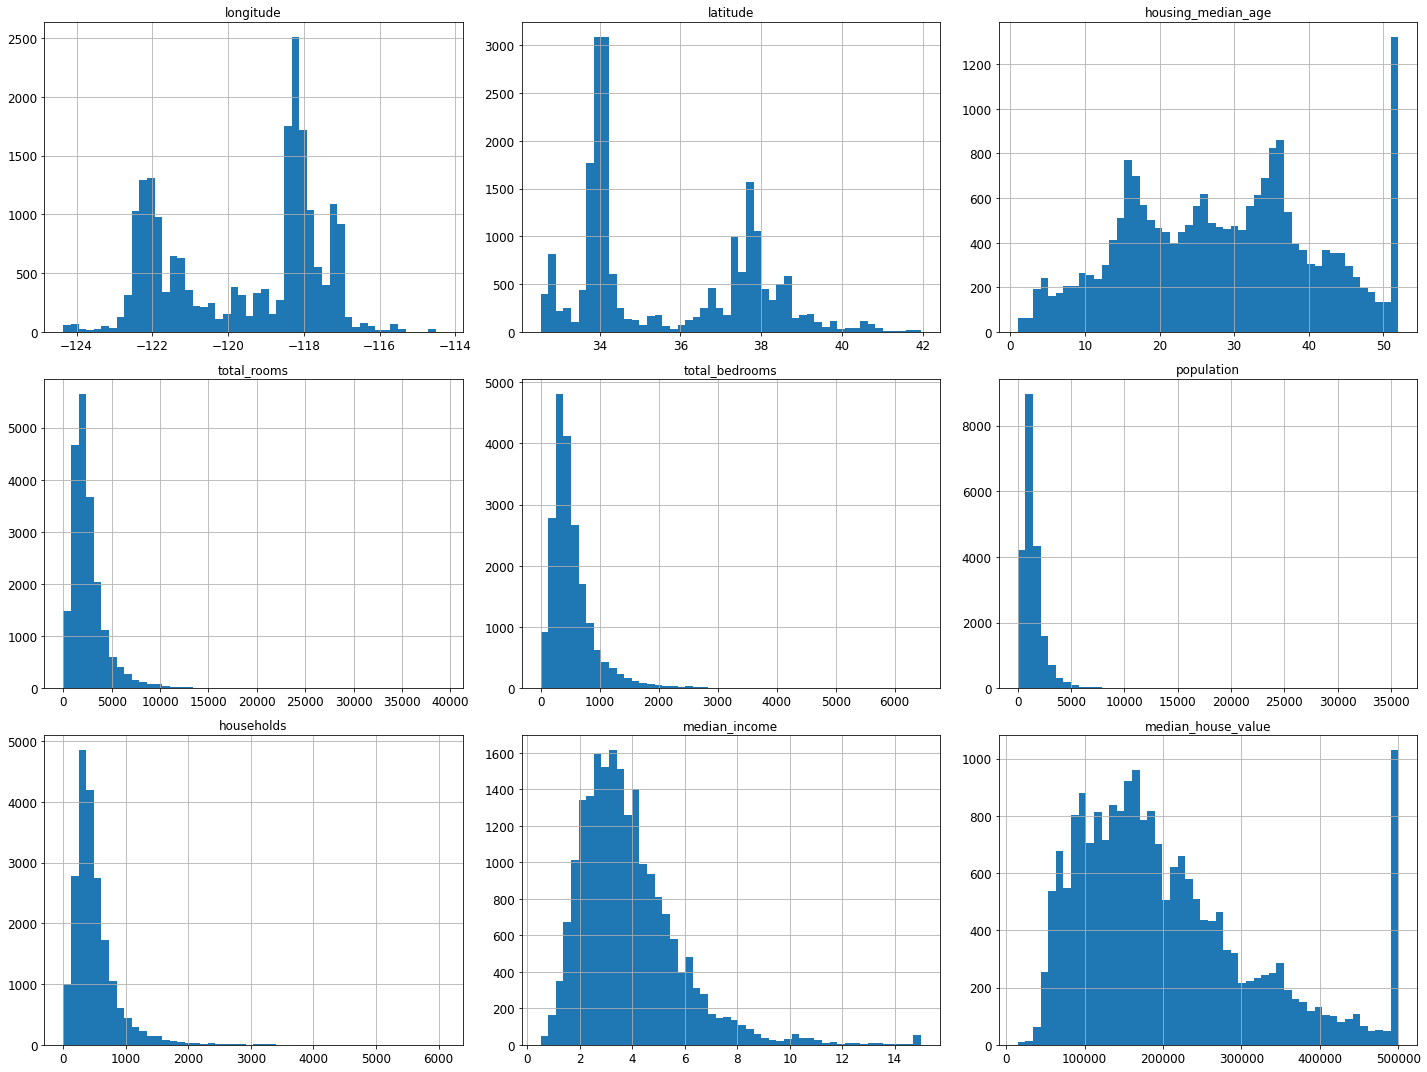

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

#### 0.3 테스트 세트 만들기

In [15]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

#### 0.4 무작위 샘플링

* 훈련 세트와 테스트 세트 구분 연습하기

In [16]:
import numpy as np

# 예시 용도로 만든 훈련 세트/테스트 세트 분류 함수. 실전용 아님.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [17]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [18]:
len(test_set)

4128

* 테스트 세트의 비율은 20%

In [19]:
len(test_set) / len(housing)

0.2

* 문제점
    - 실행할 때마다 완전히 새로 구분함
    - 따라서 반복 훈련을 진행 할 경우 테스트 세트가 모델에 노출됨.
테* 문제점
    - 실행할 때마다 완전히 새로 구분함
    - 따라서 반복 훈련을 진행 할 경우 테스트 세트가 모델에 노출됨.
    - 해결책: 샘플 고유의 식별자를 활용하여 식별자를 기준으로 훈련세트와 테스트 세트 구분

* &#x270b; `split_train_test_by_id()` 함수
    * 식별자의 체크섬을 기준으로 체크섬 값이 일정 백분율 이하인 
        샘플을 테스트 세트에 저장
    - 체크섬(checksum): 파일 전송 과정에서 발생할 수 있는 손실 여부를 판단하기 위해 사용되는 값으로
        파일이 달라지면 체크섬 값이 달라짐.
        - 참고: [위키백과: 체크섬](https://ko.wikipedia.org/wiki/체크섬)
    - `zlib.crc32()` 함수: 파일의 체크섬을 CRC 방식으로 계산한 32비트 정수 반환
        - CRC(순환 중복 검사): 파일의 체크섬을 계산하는 방식
        - `0xffffffff`: 32비트 정수 중에서 가장 큰 정수, 즉 `2**32 - 1`.
        - `test_ratio * 2**32`: 32비트 정수 중에서 `test_ratio` 비율에 해당하는 정수
            예를 들어, `test_ratio = 0.2` 이며, 하위 20%에 해당하는 정수.
    - `&`: __이진 논리곱__(binary AND)이라는 비트 연산자.
        - 이진법으로 표현된 두 숫자의 논리곱 연산자
        - 동일한 위치의 수가 둘 모두 1일 때만 1로 계산됨.
        - 여기서는 `0xffffffff`와의 비트 연산을 통해 `2**32` 보다 작은 값으로 제한하기 위해 사용됨. 
            하지만 `zlib.crc32()` 함수가 32비트 정수를 반환하기에 굳이 사용할 필요 없음.
    - 참고: [위키독스: 비트 연산자](https://wikidocs.net/20704)

In [20]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

* 고유 식별자 생성법 1: 인덱스 활용

In [21]:
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임 반환
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

* 고유 식별자 생성법 2: 경도와 위도 활용

In [22]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [23]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


* 사이킷런의 무작위 구분 함수

In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


* 무작위 구분의 단점
    - 계층별 특성을 고려하지 못함

#### 0.5 계층적 샘플링

* 전체 데이터셋의 중간 소득 히스토그램

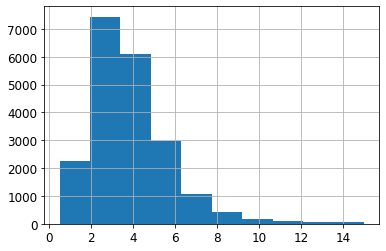

In [26]:
housing["median_income"].hist()

* 대부분 구역의 중간 소득이 **1.5~6.0**(15,000~60,000&#x24;) 사이

* 소득 구간을 아래 숫자를 기준으로 5개로 구분

    ```python
    [0, 1.5, 3.0, 4.6, 6.0, np,inf]
    ```

* 5개의 카테고리를 갖는 특성 추가
    - 특성값: 1, 2, 3, 4, 5

In [27]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

* 계층(소득 구간) 특성 히스토그램

In [28]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

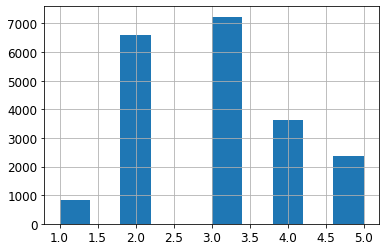

In [29]:
housing["income_cat"].hist()

* 계층별 샘플링 실행
    - `housing["income_cat"]` 기준

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

* 소득 계층 비율이 유지되었음을 확인 가능

In [31]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [32]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

* 무작위 샘플림 대 계층별 샘플링 결과 비교

In [33]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [34]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


* 데이터 되돌리기
    - `income_cat` 특성 삭제
    - 이제 본격적으로 학습 시작할 것임

In [35]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# **프로젝트 과제(변환 1~3)**

### **변환 1**

중간 소득과 중간 주택 가격 사이의 상관관계 그래프에서 확인할 수 있는 수평선에 위치한 데이터를 삭제한다.

**우선 그래프를 확인해보면 median_house_value의 500,000 값이 집중적으로 존재한다.**

In [37]:
housing = strat_train_set.copy()
# housing 값 초기화

그림 저장: income_vs_house_value_scatterplot


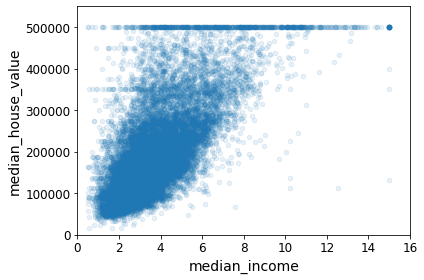

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

**한번 수치로도 확인해보자. 내림차순으로 정리를 하면 500,001 이라는 값이 있다는 것을 볼 수 있다.**

**50만 이상인 median_house_value 값을 전부 500,001로 처리한 것이라고 생각된다.**

In [39]:
housing.loc[:, ["median_income","median_house_value"]]

,median_income,median_house_value
17606,2.7042,286600.0
18632,6.4214,340600.0
14650,2.8621,196900.0
3230,1.8839,46300.0
3555,3.0347,254500.0
...,...,...
6563,4.9312,240200.0
12053,2.0682,113000.0
13908,3.2723,97800.0
11159,4.0625,225900.0


In [40]:
housing_sorted_by_values = housing.sort_values(by=["median_income","median_house_value"] ,ascending=False)
housing_sorted_by_values.loc[:, ["median_income","median_house_value"]]

,median_income,median_house_value
8851,15.0001,500001.0
6399,15.0001,500001.0
6590,15.0001,500001.0
4606,15.0001,500001.0
8848,15.0001,500001.0
...,...,...
3249,0.4999,100000.0
5213,0.4999,90600.0
19523,0.4999,82500.0
3258,0.4999,73500.0


**추가로 500,001과 동시에 수평선으로 보이는 것들도 체크해보자.**

**500,001, 450,000, 350,000, 275,000, 225,000, 187,500, 137,500,**
**112,500와 같은 수치가 두드러지는 수평선을 보이는 것 같다.**

In [41]:
housing_counts = housing.value_counts("median_house_value")
housing_counts.iloc[:20]

median_house_value
500001.0    786
137500.0    102
162500.0     91
112500.0     80
187500.0     76
225000.0     70
350000.0     65
87500.0      59
150000.0     58
175000.0     52
100000.0     51
125000.0     49
275000.0     46
67500.0      43
200000.0     40
250000.0     37
118800.0     28
450000.0     28
75000.0      27
156300.0     27
dtype: int64

**이제 이상치라고 생각하는 부분들을 제거해보자.**

In [42]:
Outlier_line = [112500, 137500, 187500, 225000, 275000, 350000, 450000, 500001]
for i in Outlier_line :
  housing = housing[housing.median_house_value != i]

**확실히 전에 있던 그래프보다 보기 좋아지고 이상치를 가지고 학습하지 않을 것이다.**

그림 저장: income_vs_house_value_scatterplot


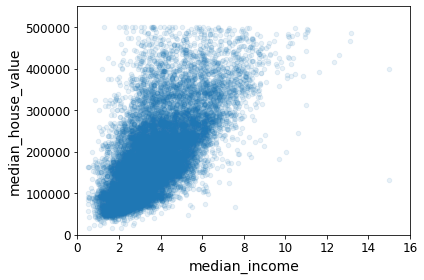

In [43]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

### **변환 2**

회귀 모델 훈련에 사용되는 12개의 특성 중에 세 개는 기존 9개의 특성을 조합하여 생성하였다. 12개의 특성 중에 중간 주택 가격과의 상관계수의 절댓값이 0.2 보다 작은 특성을 삭제한다.


**우선 12개의 특성과 중간 주택 가격과의 상관계수를 다시 확인해보자.**

In [44]:
housing = strat_train_set.drop("ocean_proximity", axis=1)
#범주형 데이터 "ocean_proximity"는 일단 제거해놓는다.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
#특성 3개 추가

corr_matrix = housing.corr()
corr_matrix["median_house_value"]

longitude                  -0.047432
latitude                   -0.142724
housing_median_age          0.114110
total_rooms                 0.135097
total_bedrooms              0.047689
population                 -0.026920
households                  0.064506
median_income               0.687160
median_house_value          1.000000
rooms_per_household         0.146285
bedrooms_per_room          -0.259984
population_per_household   -0.021985
Name: median_house_value, dtype: float64

**당연히 자기 자신(median_house_value)은 상관계수가 1일 것이고, 상관이 없으면 없을수록 수치는 낮을 것이다.**

**이제 (절대값)corr_matrix에서 0.2보다 낮은 항목을 housing 데이터프레임에서 제거해보자.**

In [45]:
corr_matrix2 = corr_matrix["median_house_value"]
delist = []
i = 0

while i < len(housing.columns):
  if abs(corr_matrix2[i]) < 0.2:
    delist.append(housing.columns[i])
  i += 1

housing = housing.drop(delist, axis=1)
housing

,median_income,median_house_value,bedrooms_per_room
17606,2.7042,286600.0,0.223852
18632,6.4214,340600.0,0.159057
14650,2.8621,196900.0,0.241291
3230,1.8839,46300.0,0.200866
3555,3.0347,254500.0,0.231341
...,...,...,...
6563,4.9312,240200.0,0.185681
12053,2.0682,113000.0,0.245819
13908,3.2723,97800.0,0.179609
11159,4.0625,225900.0,0.193878


**제거된 열을 제외하고 출력된 것을 확인할 수 있다.**

In [46]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"]

median_income         0.687160
median_house_value    1.000000
bedrooms_per_room    -0.259984
Name: median_house_value, dtype: float64

### **변환 3**

범주형 특성을 제외한 9개 특성별 히스토그램을 보면 일부 특성의 히스토그램이 좌우 비대칭이다. (전문 용어로 왜도(skewness)가 0이 아닐 때 이런 분포가 발생한다.) 대표적으로 방의 총 개수(total_rooms), 침실 총 개수(total_bedrooms), 인구(population), 가구수(households), 중간소득(median_income) 등 다섯 개의 특성이 그렇다. 앞서 언급된 5개 특성 또는 일부에 대해 로그 변환을 적용한다.

**우선 다시 housing 데이터프레임을 불러온다.**

In [47]:
housing = strat_train_set.copy()
# housing 값 초기화

**9개 특성들의 히스토그램을 확인해보면**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2da9626490>,
      dtype=object)

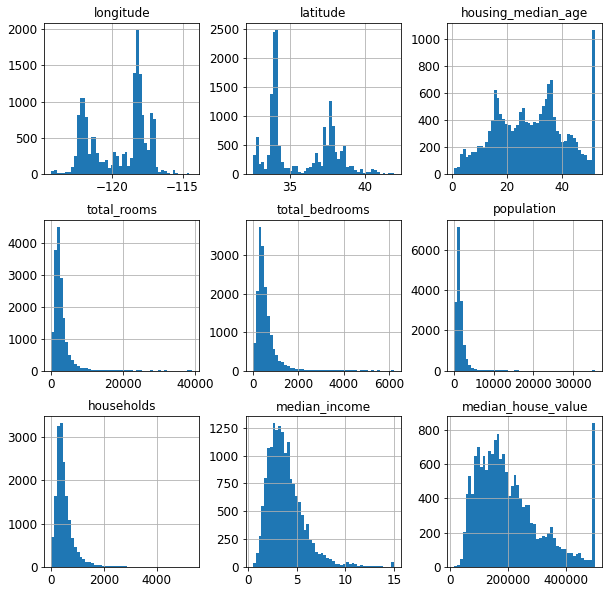

In [48]:
housing.hist(bins=50,figsize=(10,10))

**여기서 방의 총 개수(total_rooms), 침실 총 개수(total_bedrooms),**

**인구(population), 가구수(households), 중간소득(median_income)**

**이 5개의 특성이 좌우 비대칭인 것을 확인할 수 있다.**

**우선 자세하게 total_rooms 특성부터 살펴보자.**

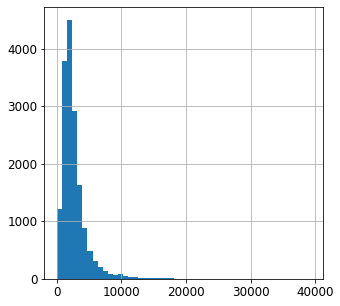

In [49]:
housing["total_rooms"].hist(bins=50,figsize=(5,5))

**여기서 그냥 numpy에서 로그변환을 가져와서 시키면 된다.**

In [50]:
housing["total_rooms"] = np.log1p(housing["total_rooms"])

**밑은 로그 변환 후 히스토그램이다. 확실히 좌우비대칭이 괜찮아졌다.**

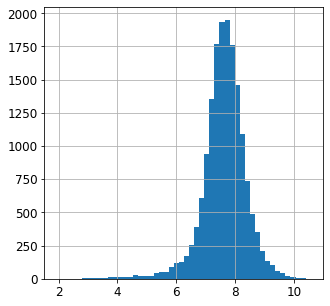

In [51]:
housing["total_rooms"].hist(bins=50,figsize=(5,5))

**다른 4개의 특성도 로그변환을 시키고 히스토그램으로 확인해보면**

**좌우비대칭 현상이 해결된 것을 확인할 수 있다.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2da9422dd0>,
      dtype=object)

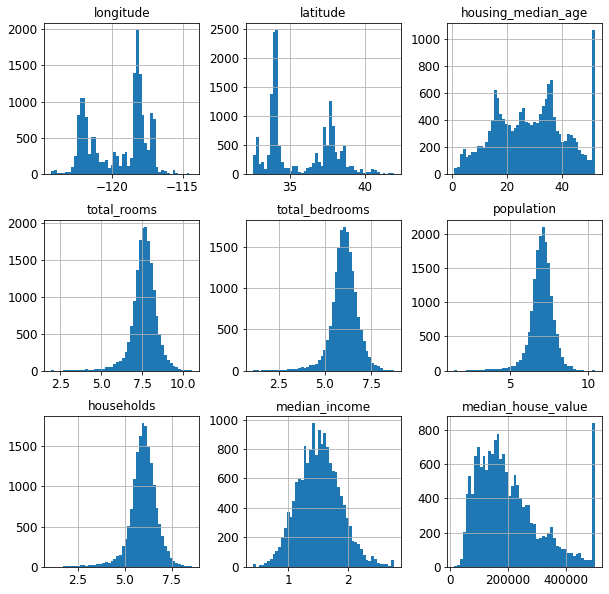

In [52]:
housing["total_bedrooms"] = np.log1p(housing["total_bedrooms"])
housing["population"] = np.log1p(housing["population"])
housing["households"] = np.log1p(housing["households"])
housing["median_income"] = np.log1p(housing["median_income"])
housing.hist(bins=50,figsize=(10,10))

# **실제 데이터와 변환 적용한 데이터 비교**

## **1. 원본(수정) (RMSE = 47730.22690385927)**

#### **1.1 알고리즘을 위한 데이터 준비**

In [53]:
housing = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

##### 1.1.1 데이터 정제

In [54]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [55]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [56]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [57]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [58]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [59]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [60]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [61]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [62]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [63]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

훈련 세트를 변환합니다:

In [64]:
X = imputer.transform(housing_num)

In [65]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [66]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [67]:
imputer.strategy

'median'

In [68]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


##### 1.1.2 텍스트와 범주형 특성 다루기 (p.102)

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [69]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [70]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [71]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [72]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [73]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [74]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [75]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [76]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [77]:
#housing = housing.drop("ocean_proximity", axis=1)

In [78]:
import scipy as sp
import numpy as np

one_hot_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.categories_)
one_hot_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
16507,0.0,1.0,0.0,0.0,0.0
16508,0.0,1.0,0.0,0.0,0.0
16509,0.0,1.0,0.0,0.0,0.0
16510,1.0,0.0,0.0,0.0,0.0


In [79]:
housing = housing.reset_index(drop=True)

In [80]:
pd.concat([housing, one_hot_df], axis = 1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,0.0,1.0,0.0,0.0,0.0
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,0.0,1.0,0.0,0.0,0.0
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,0.0,1.0,0.0,0.0,0.0
16509,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,0.0,1.0,0.0,0.0,0.0
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,1.0,0.0,0.0,0.0,0.0


##### 1.1.3 나만의 변환기 (p.105)

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

책에서는 간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋습니다:

In [82]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

또한 `housing_extra_attribs`는 넘파이 배열이기 때문에 열 이름이 없습니다(안타깝지만 사이킷런을 사용할 때 생기는 문제입니다). `DataFrame`으로 복원하려면 다음과 같이 할 수 있습니다:

In [83]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


##### 1.1.4 변환 파이프라인 (p.108)

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [85]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [86]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [87]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [88]:
housing_prepared.shape

(16512, 16)

다음은 (판다스 `DataFrame` 열의 일부를 선택하기 위해) `DataFrameSelector` 변환기와 `FeatureUnion`를 사용한 예전 방식입니다:

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [90]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [91]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [92]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

`ColumnTransformer`의 결과와 동일합니다:

In [93]:
np.allclose(housing_prepared, old_housing_prepared)

True

#### **1.2 모델 선택과 훈련**

##### 1.2.1 훈련 세트에서 훈련하고 평가하기 (p. 110)

In [94]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [95]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


실제 값과 비교합니다:

In [96]:
print("레이블:", list(some_labels))

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [97]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [98]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

**노트**: 사이킷런 0.22 버전부터는 `squared=False` 매개변수로 `mean_squared_error()` 함수를 호출하면 RMSE를 바로 얻을 수 있습니다.

In [99]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [100]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [101]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

##### 1.2.2 교차 검증을 사용한 평가 (p. 112)

In [102]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [103]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균: 71407.68766037929
표준 편차: 2439.4345041191004


In [104]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준 편차: 2731.674001798344


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [105]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [106]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [107]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준 편차: 2097.0810550985693


In [108]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [109]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

#### **1.3 모델 세부 튜팅**

##### 1.3.1 그리드 탐색 (p.115)

In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

최상의 파라미터 조합은 다음과 같습니다:

In [111]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [112]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [114]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.073731,0.002673,0.003784,0.000258,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.241444,0.004026,0.011805,0.000578,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.722058,0.004012,0.033404,0.001739,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.123552,0.006327,0.004670,0.000970,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.397702,0.002596,0.011654,0.000084,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.184642,0.007795,0.033259,0.001447,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.164980,0.004086,0.004331,0.000024,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.548568,0.006016,0.012129,0.000764,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.688891,0.007969,0.033008,0.000419,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.211458,0.003894,0.004566,0.000397,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


데이터 전처리와 그리드 탐색을 연결한 파이프라인을 이용하면 전처리 단계에서 
설정해야 하는 값들을 일종의 하이퍼파라미터로 다룰 수 있다.
예를 들어, 

* `CombinedAttributesAdder` 클래스의 객체를 생성할 때 지정하는 `add_bedrooms_per_room` 옵션 변수 값 지정하기
* 이상치 처리하기
* 누락된 값 처리하기
* 특성 선택하기

등에 대해 어떻게 설정하는 것이 좋은지도 함께 찾아준다. 
조금은 고급 기술이지만, 지금까지 배운 내용을 이해한다면
어렵지 않게 적용할 수 있는 기술이다. 
파이프라인과 그리드 탐색을 연동한 예제들을 아래 사이트에서 살펴볼 수 있다.

* [알고리즘 체인과 파이프라인](https://bizzengine.tistory.com/171)
* [Pipeline에서 캐싱 사용하기](https://tensorflow.blog/2017/12/08/pipeline에서-캐싱을-사용하기/)
* [A Super Quick Guide to Randomized (or Grid) Search with Pipeline](https://medium.com/swlh/randomized-or-grid-search-with-pipeline-cheatsheet-719c72eda68)

##### 1.3.2 랜덤 탐색 (p. 118)

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [116]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


##### 1.3.3 최상의 모델과 오차 분석 (p.118)

In [117]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [118]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

##### 1.3.4 테스트 세트로 시스템 평가하기 **(결과)**

**결과를 확인해보면 rmse = 47730.22690385927 값이 나오는 것을 확인할 수 있다.**

In [119]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [120]:
final_rmse

47730.22690385927

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [121]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

다음과 같이 수동으로 계산할 수도 있습니다:

In [122]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

또는 t-점수 대신 z-점수를 사용할 수도 있습니다:

In [123]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

In [124]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [125]:
my_model = full_pipeline_with_predictor

In [126]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

**원본 데이터 세트로 시스템 평가를 진행하면 rmse 값은 47730.22690385927이 나온다.**

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [127]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

책에서는 간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋습니다:

In [128]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

또한 `housing_extra_attribs`는 넘파이 배열이기 때문에 열 이름이 없습니다(안타깝지만 사이킷런을 사용할 때 생기는 문제입니다). `DataFrame`으로 복원하려면 다음과 같이 할 수 있습니다:

In [129]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [130]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

최상의 파라미터 조합은 다음과 같습니다:

In [131]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [132]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [133]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [134]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.075756,0.001743,0.004408,0.000411,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.245394,0.005938,0.012317,0.001376,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.731683,0.009040,0.032861,0.000451,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.123906,0.001940,0.004356,0.000191,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.404452,0.002819,0.011744,0.000080,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.204350,0.006898,0.032930,0.000274,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.166150,0.006374,0.004481,0.000530,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.551571,0.003916,0.011812,0.000297,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.675028,0.011496,0.033370,0.001174,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.211379,0.001405,0.004241,0.000047,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## **2. 변환 적용 (RMSE = 23654.49999171906)**

### **2.1 알고리즘을 위한 데이터 준비 및 변환 1~3 적용**

우선 훈련할 데이터프레임을 준비한다.

In [135]:
housing = strat_test_set.copy()

**여기서 변환 1처럼 housing에 'median_house_value'에서 이상치를 제거한다.**

In [136]:
Outlier_line = [112500, 137500, 187500, 225000, 275000, 350000, 450000, 500001]
for i in Outlier_line :
  housing = housing[housing.median_house_value != i]

#### 2.1.1 데이터 정제(결측값 제거 or 평균값 적용)

In [137]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4309,-118.32,34.09,44.0,2666.0,NaN,2297.0,726.0,1.6760,208800.0,<1H OCEAN
11096,-117.87,33.83,27.0,2287.0,NaN,1140.0,351.0,5.6163,231000.0,<1H OCEAN
3912,-118.55,34.19,18.0,5862.0,NaN,3161.0,1280.0,3.1106,170600.0,<1H OCEAN
15030,-117.02,32.78,31.0,2567.0,NaN,1198.0,499.0,3.4659,163000.0,<1H OCEAN
10885,-117.92,33.70,15.0,3201.0,NaN,1510.0,622.0,4.2708,161700.0,<1H OCEAN


In [138]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


In [139]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
4309,-118.32,34.09,44.0,2666.0,2297.0,726.0,1.6760,208800.0,<1H OCEAN
11096,-117.87,33.83,27.0,2287.0,1140.0,351.0,5.6163,231000.0,<1H OCEAN
3912,-118.55,34.19,18.0,5862.0,3161.0,1280.0,3.1106,170600.0,<1H OCEAN
15030,-117.02,32.78,31.0,2567.0,1198.0,499.0,3.4659,163000.0,<1H OCEAN
10885,-117.92,33.70,15.0,3201.0,1510.0,622.0,4.2708,161700.0,<1H OCEAN


In [140]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [141]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4309,-118.32,34.09,44.0,2666.0,445.0,2297.0,726.0,1.6760,208800.0,<1H OCEAN
11096,-117.87,33.83,27.0,2287.0,445.0,1140.0,351.0,5.6163,231000.0,<1H OCEAN
3912,-118.55,34.19,18.0,5862.0,445.0,3161.0,1280.0,3.1106,170600.0,<1H OCEAN
15030,-117.02,32.78,31.0,2567.0,445.0,1198.0,499.0,3.4659,163000.0,<1H OCEAN
10885,-117.92,33.70,15.0,3201.0,445.0,1510.0,622.0,4.2708,161700.0,<1H OCEAN


In [142]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [143]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [144]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [145]:
imputer.statistics_

array([-1.1846e+02,  3.4250e+01,  2.8000e+01,  2.1680e+03,  4.4500e+02,
        1.1930e+03,  4.1900e+02,  3.4659e+00,  1.7420e+05])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [146]:
housing_num.median().values

array([-1.1846e+02,  3.4250e+01,  2.8000e+01,  2.1680e+03,  4.4500e+02,
        1.1930e+03,  4.1900e+02,  3.4659e+00,  1.7420e+05])

훈련 세트를 변환합니다:

In [147]:
X = imputer.transform(housing_num)

In [148]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [149]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4309,-118.32,34.09,44.0,2666.0,445.0,2297.0,726.0,1.6760,208800.0
11096,-117.87,33.83,27.0,2287.0,445.0,1140.0,351.0,5.6163,231000.0
3912,-118.55,34.19,18.0,5862.0,445.0,3161.0,1280.0,3.1106,170600.0
15030,-117.02,32.78,31.0,2567.0,445.0,1198.0,499.0,3.4659,163000.0
10885,-117.92,33.70,15.0,3201.0,445.0,1510.0,622.0,4.2708,161700.0


In [150]:
imputer.strategy

'median'

In [151]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0
20552,-121.80,38.68,11.0,3851.0,892.0,1847.0,747.0,3.4331,120600.0


#### 2.1.2 텍스트와 범주형 특성 다루기('ocean_proximity' 특성 제거)

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [152]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
10970,<1H OCEAN
20351,<1H OCEAN
6568,INLAND
13285,INLAND
20552,INLAND
19989,INLAND
13692,INLAND
13916,INLAND
20374,<1H OCEAN
18776,INLAND


In [153]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [154]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [155]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<3825x5 sparse matrix of type '<class 'numpy.float64'>'
	with 3825 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [156]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [157]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [158]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [159]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<3825x5 sparse matrix of type '<class 'numpy.float64'>'
	with 3825 stored elements in Compressed Sparse Row format>

In [160]:
#housing = housing.drop("ocean_proximity", axis=1)

In [161]:
import scipy as sp
import numpy as np

one_hot_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.categories_)
one_hot_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
3820,0.0,1.0,0.0,0.0,0.0
3821,0.0,0.0,0.0,0.0,1.0
3822,1.0,0.0,0.0,0.0,0.0
3823,0.0,1.0,0.0,0.0,0.0


In [162]:
housing = housing.reset_index(drop=True)

In [163]:
housing = pd.concat([housing, one_hot_df], axis = 1)

In [164]:
housing = housing.drop("ocean_proximity", axis=1)

#### 2.1.3 **변환 2, 3**

**우선 변환 3이 로그함수를 취하는 것이기 때문에 먼저 적용한다.**

In [165]:
# 변환 3
housing["total_rooms"] = np.log1p(housing["total_rooms"])
housing["total_bedrooms"] = np.log1p(housing["total_bedrooms"])
housing["population"] = np.log1p(housing["population"])
housing["households"] = np.log1p(housing["households"])
housing["median_income"] = np.log1p(housing["median_income"])

**또한, 특성 3개를 추가한다.**

In [166]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
#특성 3개 추가

**이미 범주형을 수치형으로 바꾸고 특성에 적용했기 때문에 변환 2를 적용하면 된다.**

In [167]:
# 변환 2
corr_matrix = housing.corr()
corr_matrix2 = abs(corr_matrix["median_house_value"])
delist = []
i = 0

while i < len(housing.columns):
  if corr_matrix2[i] < 0.2:
    delist.append(housing.columns[i])
  i += 1

housing = housing.drop(delist, axis=1)
housing

,median_income,median_house_value,"(<1H OCEAN,)","(INLAND,)",population_per_household
0,1.724747,240300.0,1.0,0.0,1.145143
1,1.389265,218200.0,1.0,0.0,1.129626
2,1.639346,182100.0,0.0,1.0,1.198857
3,1.616910,121300.0,0.0,1.0,1.220488
4,1.489099,120600.0,0.0,1.0,1.136678
...,...,...,...,...,...
3820,1.089504,76400.0,0.0,1.0,1.115807
3821,1.090244,134000.0,0.0,0.0,1.176936
3822,1.774681,311700.0,1.0,0.0,1.118708
3823,1.742394,133500.0,0.0,1.0,1.156589


**적용 결과 상관계수가 0.2 이하인 특성은 제거되었다.**

**마무리로 'median_house_value' 특성을 housing 데이터프레임에서 제거하고 housing_labels에 따로 넣어놓는다.**

In [168]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제

#### 2.1.4 **변환 파이프라인**

**수치형 특성을 전처리하기 위해 파이프라인을 만든다.**

In [169]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_prepared = num_pipeline.fit_transform(housing)

**하지만 원본과 다르게 범주형을 미리 수치형으로 바꿔놓아서 0과 1로 이루어져야 할 2, 3번째 열이 1.4와 -0.7로 구성되어 있다.**

In [170]:
housing_prepared

array([[ 0.69872277,  1.11744228, -0.70087664, -0.48992832],
       [-0.31600474,  1.11744228, -0.70087664, -0.71399503],
       [ 0.44041266, -0.89490081,  1.4267846 ,  0.28567843],
       ...,
       [ 0.84975854,  1.11744228, -0.70087664, -0.87163833],
       [ 0.75210051, -0.89490081,  1.4267846 , -0.324654  ],
       [ 0.2174513 , -0.89490081,  1.4267846 ,  0.18094796]])

**이하 0과 1로 이루어지게 하기 위해서 파이프라인 적용 전 housing에 있는 데이터를 housing_prepared에 적용하는 과정이다.**

**<1H OCEAN 부터 적용해보자.**

In [171]:
ilst = list(np.array(housing.iloc[:,1].tolist()))
ilst2 = []
i = 0

while i < len(ilst) :
  ilst2.append([ilst[i]])
  i += 1
  
housing_prepared[:,[1]] = ilst2

**반복문을 사용하면 되지만 한번 더 사용해서 INLAND 항목도 바꿔주었다.**

In [172]:
ilst = list(np.array(housing.iloc[:,2].tolist()))
ilst2 = []
i = 0
while i < len(ilst) :
  ilst2.append([ilst[i]])
  i += 1
housing_prepared[:,[2]] = ilst2

**성공적으로 적용하였다.**

In [173]:
housing_prepared

array([[ 0.69872277,  1.        ,  0.        , -0.48992832],
       [-0.31600474,  1.        ,  0.        , -0.71399503],
       [ 0.44041266,  0.        ,  1.        ,  0.28567843],
       ...,
       [ 0.84975854,  1.        ,  0.        , -0.87163833],
       [ 0.75210051,  0.        ,  1.        , -0.324654  ],
       [ 0.2174513 ,  0.        ,  1.        ,  0.18094796]])

In [174]:
housing_prepared.shape

(3825, 4)

### **2.2 모델 선택과 훈련**

**모델 선택과 훈련에서 따로 바꿀 내용은 없기 때문에 약간의 수정만 하였다.**

**ex) 변환 적용에 따른 파이프라인의 transform 항목 제거**

##### 2.2.1 교차 검증을 사용한 평가 (p. 112)

In [175]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [176]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [77697.36311476 77602.91490717 77140.81018048 79333.33840023
 80693.22220398 83968.49306273 82017.56835169 85870.58797738
 84456.23677603 79337.3321803 ]
평균: 80811.78671547429
표준 편차: 2968.815172358624


In [177]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [60760.79713215 64794.52182928 60970.09857881 62272.59618758
 69197.96529907 65123.8049494  62991.55649597 58848.39293478
 65417.32956484 64469.86482141]
평균: 63484.69277932766
표준 편차: 2805.350279527959


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [178]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [179]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22925.449436433246

In [180]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [61866.53256173 62373.77008567 60223.17847966 59497.55647123
 63792.15328368 60100.00748396 63288.61654002 58050.76324036
 63063.16415009 61881.88460613]
평균: 61413.76269025303
표준 편차: 1770.9644804718287


In [181]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     63484.692779
std       2957.098839
min      58848.392935
25%      61295.722981
50%      63730.710659
75%      65041.484169
max      69197.965299
dtype: float64

In [182]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

97387.4906726381

### **2.3 모델 세부 튜팅**

**모델 세부 튜닝에서 따로 바꿀 내용은 없기 때문에 약간의 수정만 하였다.**

**ex) 파라미터 값 설정 변경**

#### 2.3.1 그리드 탐색 (p.115)

상관계수가 낮은 특성은 제거하였기 때문에 'max_fatures' 수치를 수정하였다.

In [183]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

최상의 파라미터 조합은 다음과 같습니다:

In [184]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [185]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [186]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

67889.07359833093 {'max_features': 2, 'n_estimators': 3}
62939.68210829389 {'max_features': 2, 'n_estimators': 10}
61426.63997668008 {'max_features': 2, 'n_estimators': 30}
68658.64272288956 {'max_features': 3, 'n_estimators': 3}
62779.91520182231 {'max_features': 3, 'n_estimators': 10}
61520.99358149143 {'max_features': 3, 'n_estimators': 30}
69075.49784814547 {'max_features': 4, 'n_estimators': 3}
63832.9164379589 {'max_features': 4, 'n_estimators': 10}
61913.367380477204 {'max_features': 4, 'n_estimators': 30}
71432.45751890287 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
67329.20010071111 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
72564.13705673715 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
68869.9072946684 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
81041.5454306058 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
80576.89294191488 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [187]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017516,0.002323,0.001939,0.000057,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.682125e+09,-4.805538e+09,-4.646635e+09,-4.386483e+09,-4.523851e+09,-4.608926e+09,1.429370e+08,8,-1.085485e+09,-1.077459e+09,-1.067861e+09,-1.060714e+09,-1.102969e+09,-1.078898e+09,1.467878e+07
1,0.048724,0.001737,0.003689,0.000148,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-4.110203e+09,-3.913931e+09,-3.916510e+09,-3.778155e+09,-4.088219e+09,-3.961404e+09,1.233469e+08,5,-6.743211e+08,-6.868236e+08,-6.747280e+08,-6.725608e+08,-6.632484e+08,-6.743364e+08,7.512402e+06
2,0.142155,0.003820,0.008515,0.000204,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.913594e+09,-3.705669e+09,-3.842011e+09,-3.507822e+09,-3.897064e+09,-3.773232e+09,1.515080e+08,1,-5.654872e+08,-5.659831e+08,-5.587026e+08,-5.694516e+08,-5.554817e+08,-5.630212e+08,5.132221e+06
3,0.019343,0.000856,0.001830,0.000058,3,3,NaN,"{'max_features': 3, 'n_estimators': 3}",-4.829945e+09,-4.465270e+09,-4.459788e+09,-4.924074e+09,-4.890969e+09,-4.714009e+09,2.075489e+08,9,-1.119936e+09,-1.155767e+09,-1.103662e+09,-1.123585e+09,-1.194039e+09,-1.139398e+09,3.212302e+07
4,0.059168,0.001658,0.003664,0.000084,3,10,NaN,"{'max_features': 3, 'n_estimators': 10}",-3.993334e+09,-3.684617e+09,-3.860363e+09,-4.057859e+09,-4.110416e+09,-3.941318e+09,1.531864e+08,4,-6.774293e+08,-7.036797e+08,-6.733347e+08,-6.785365e+08,-6.882719e+08,-6.842504e+08,1.088115e+07
5,0.175937,0.005222,0.008557,0.000389,3,30,NaN,"{'max_features': 3, 'n_estimators': 30}",-3.905485e+09,-3.523840e+09,-3.820371e+09,-3.653915e+09,-4.020552e+09,-3.784833e+09,1.769973e+08,2,-5.529002e+08,-5.692473e+08,-5.650103e+08,-5.787167e+08,-5.715086e+08,-5.674766e+08,8.535641e+06
6,0.022610,0.000206,0.001913,0.000056,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-5.044267e+09,-4.702763e+09,-4.608572e+09,-4.794382e+09,-4.707139e+09,-4.771424e+09,1.485517e+08,11,-1.100283e+09,-1.079149e+09,-1.097551e+09,-1.132851e+09,-1.206080e+09,-1.123183e+09,4.491284e+07
7,0.070649,0.001685,0.003677,0.000075,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-4.151477e+09,-3.980786e+09,-3.915292e+09,-4.166420e+09,-4.159231e+09,-4.074641e+09,1.055307e+08,6,-6.846068e+08,-7.126348e+08,-6.778597e+08,-6.984110e+08,-6.755126e+08,-6.898050e+08,1.392298e+07
8,0.208374,0.003586,0.008360,0.000116,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-3.956666e+09,-3.668578e+09,-3.778456e+09,-3.740569e+09,-4.022057e+09,-3.833265e+09,1.338569e+08,3,-5.671605e+08,-5.792185e+08,-5.695208e+08,-5.867805e+08,-5.642213e+08,-5.733803e+08,8.379983e+06
9,0.022281,0.001596,0.002029,0.000259,2,3,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-5.157360e+09,-5.055737e+09,-5.161382e+09,-4.718076e+09,-5.420426e+09,-5.102596e+09,2.269458e+08,12,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00


#### 2.3.2 최상의 모델과 오차 분석 (p.118)

In [188]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.53994085, 0.03048519, 0.17934518, 0.25022878])

#### 2.3.3 테스트 세트로 시스템 평가하기 **(결과)**

**결과를 확인해보면 rmse = 23654.49999171906 값이 나오는 것을 확인할 수 있다.**

In [189]:
final_model = grid_search.best_estimator_

X_test = housing
y_test = housing_labels

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [190]:
final_rmse

23654.49999171906

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [191]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([22793.42057051, 24485.31638375])

다음과 같이 수동으로 계산할 수도 있습니다:

In [192]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(22793.42057050913, 24485.316383750298)